In [1]:
from imports import *

## 2.2. Quantum Teleportation – Sending Secrets with Spooky Action

Imagine Alice has a qubit called `q0`, which holds a special quantum state `|ψ⟩` that she wants to send to Bob, who is far away. She can’t measure the qubit to figure out its state — doing so would destroy the information. And she can’t just send the qubit through physical means, because it might be too fragile or even forbidden in the setup. So, how can she get this exact quantum state into Bob’s hands?

The answer is quantum teleportation. It’s not science fiction — it’s a real and working method in quantum information science. This process doesn't move the physical particle, but it **transfers the state** of Alice’s qubit to Bob’s, using a combination of entanglement and classical communication.

Here's how it works, step by step:

1. **Alice prepares the state to teleport**  
   Alice sets her qubit `q0` to the state `|ψ⟩`. For testing purposes, this state might be something like `|+⟩` (a balanced superposition), but it can be any unknown quantum state.

2. **Entanglement is created between two other qubits**  
   A second qubit `q1` (with Alice) and a third qubit `q2` (with Bob) are entangled. This means they share a special quantum link. Now, Alice holds two qubits (`q0` and `q1`), and Bob holds one (`q2`).

3. **Alice performs special operations on her two qubits**  
   She mixes `q0` (the one with the state to teleport) and `q1` (her half of the entangled pair) using quantum gates. Then she measures both of them. These measurements give her two classical bits: `c0` and `c1`.

4. **She sends the two classical bits to Bob**  
   These bits (`c0`, `c1`) contain the minimal information Bob needs to reconstruct the state. She sends them through a normal classical channel — like a message or phone call.

5. **Bob adjusts his qubit using the classical bits**  
   Bob applies corrections on his qubit `q2`:
   - If `c1 = 1`, he applies an X gate.
   - If `c0 = 1`, he applies a Z gate.
   If both are 0, he does nothing. These corrections transform `q2` into the exact same quantum state `|ψ⟩` that Alice had in `q0`.

At this point, Alice’s original qubit has been measured and no longer holds the state — but Bob’s qubit now does. The quantum state has been “teleported” from Alice to Bob. No particles moved, but the information did.

This is possible because of two key features in quantum computing:
- **Entanglement**, which links two qubits in a way that can't be described classically.
- **Mid-circuit measurement and classical control**, which allow measurement results to influence later operations in the same circuit.

One important detail is that Bob must apply the gates in the correct order — first the X gate, then the Z gate — because quantum operations are order-sensitive.

Quantum teleportation may sound like magic, but it's a carefully designed and experimentally verified protocol. It’s a powerful demonstration of how quantum systems can transmit information in ways that are impossible for classical systems.


### **How to implement it ? **
### Building the Teleportation Circuit in Qiskit

To implement quantum teleportation in Qiskit, we need to build a circuit that transfers the state of Alice’s qubit to Bob’s, using entanglement and mid-circuit measurements. The process involves a few key operations that must be performed in sequence to ensure the teleportation works correctly. Here's what we need to do:

- First, create an entangled Bell pair between qubits `q1` and `q2`. This shared entanglement forms the quantum link between Alice and Bob.
- Next, apply a set of quantum gates to perform a Bell measurement on Alice’s two qubits: the message qubit `q0` and her half of the entangled pair `q1`. This step prepares the qubits for teleportation and extracts classical information.
- Finally, use the results of Alice’s measurements to apply conditional correction gates (X and Z) on Bob’s qubit `q2`. These operations will reconstruct the original quantum state on Bob’s side.

By carefully following these steps, we can complete the quantum teleportation protocol using Qiskit’s dynamic circuit capabilities.

Full Teleportation Circuit


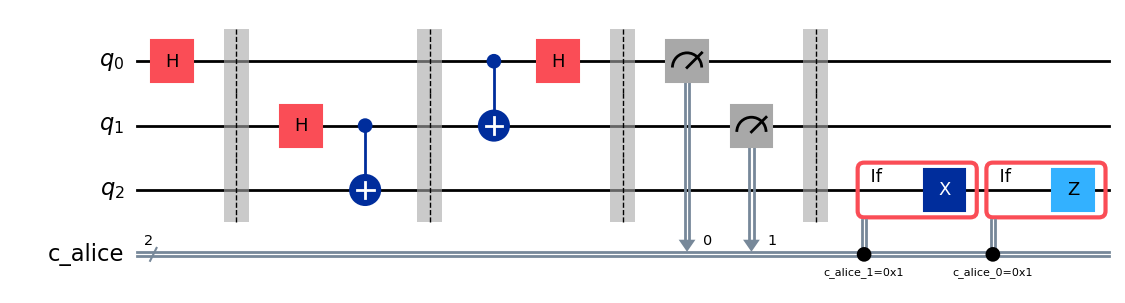

In [2]:
# Define quantum and classical registers
quantum_reg_tele = QuantumRegister(3, name='q')
classical_reg = ClassicalRegister(2, name='c_alice') # For Alice's measurements

# For verification with statevector, we don't measure Bob's final qubit in this circuit.
# If we were to run on hardware and verify by counts, we'd add a classical bit for Bob.
teleportation_circuit = QuantumCircuit(quantum_reg_tele, classical_reg, name='Teleportation')

# Prepare Alice's message state |ψ> = |+> on q0
teleportation_circuit.h(quantum_reg_tele[0])
teleportation_circuit.barrier()


# Step 1: Create Bell pair between q1 (Alice) and q2 (Bob)
teleportation_circuit.h(quantum_reg_tele[1])
teleportation_circuit.cx(quantum_reg_tele[1], quantum_reg_tele[2])



teleportation_circuit.barrier()

# Step 2: Alice's Bell Measurement (gates part))
teleportation_circuit.cx(quantum_reg_tele[0], quantum_reg_tele[1])
teleportation_circuit.h(quantum_reg_tele[0])



teleportation_circuit.barrier()

# Alice measures her qubits q0 and q1
teleportation_circuit.measure(quantum_reg_tele[0], classical_reg[0]) # q0 -> c0
teleportation_circuit.measure(quantum_reg_tele[1], classical_reg[1]) # q1 -> c1
teleportation_circuit.barrier()


# Step 3: Bob's Conditional Corrections on q2
# IMPORTANT: .c_if() on gates like XGate() no longer works directly as in older Qiskit versions.
# The recommended method in Qiskit 1.0+ is to use the new `if_test` context manager.
with teleportation_circuit.if_test((classical_reg[1], 1)):
    teleportation_circuit.x(quantum_reg_tele[2])
with teleportation_circuit.if_test((classical_reg[0],1)):
    teleportation_circuit.z(quantum_reg_tele[2])

# --- End of TODO --

print("Full Teleportation Circuit")
teleportation_circuit.draw('mpl')

### **Analyzing the Results**

Using statevector simulator...
Running statevector simulation...
Simulation successful.
Statevector retrieved successfully.

Visualizing final qubit states (q2 should match initial q0 state |+>):


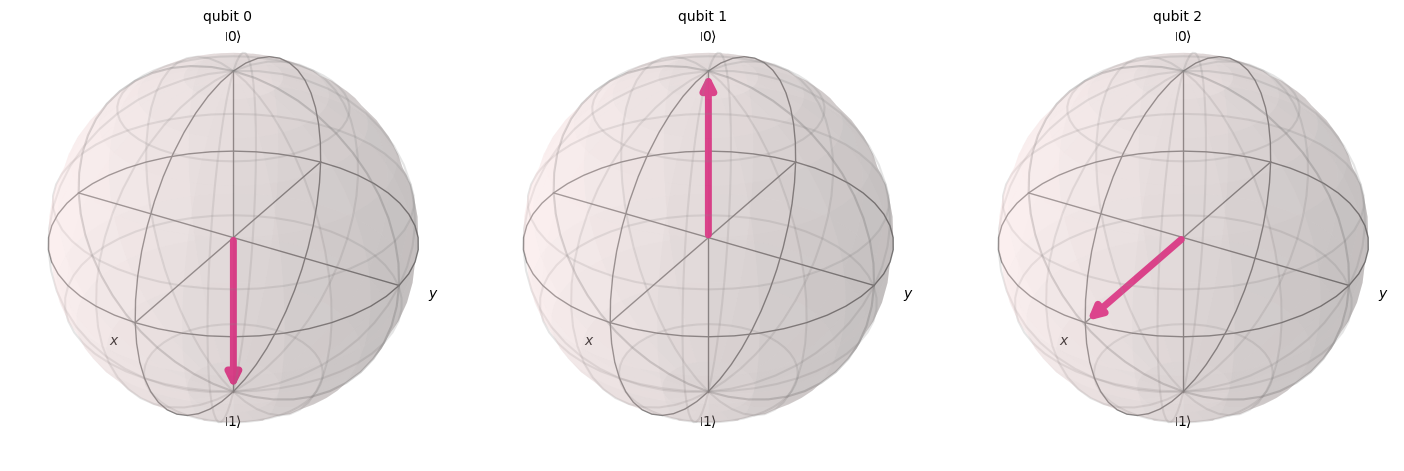

In [3]:
%matplotlib inline

# Use Statevector Simulator
print("Using statevector simulator...")
sv_simulator = AerSimulator(method='statevector') # Explicitly set method for clarity
teleportation_circuit_sv = teleportation_circuit.copy() # Work with a copy for statevector simulation
teleportation_circuit_sv.save_statevector() # Save statevector at the end

print("Running statevector simulation...")
job_sv = sv_simulator.run(teleportation_circuit_sv) # shots=1 is default for statevector
result_sv = job_sv.result()

if result_sv.success:
    print("Simulation successful.")
    final_statevector = result_sv.get_statevector()
    print("Statevector retrieved successfully.")
    print("\nVisualizing final qubit states (q2 should match initial q0 state |+>):")
    # q0 was |+> (points along +X). After teleportation, q2 should be |+>.
    # q0 and q1 states are after Alice's measurement, so they'll be collapsed.
    
    plot_bloch_multivector(final_statevector)
        
else:
    print(f"Statevector simulation failed! Status: {result_sv.status}")